<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/interp/legacy-innovation-hh-bl-to-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geschäftslogik durch Machine Learning ersetzen?

https://www.meetup.com/en-AU/Legacy-Innovation-Hamburg/events/268268757/

_Manche Geschäftslogik folgt festen Regeln oder gar Gesetzen und lässt sich dementsprechend klar mit Wenn-Dann-Regeln lösen. In anderen Fällen erweist sie sich jedoch als besorgniserregend schwammig, schwer zu bewerten und ebenso schwer zu warten. Am Beispiel eines Anwendungsfalls aus der Versicherungsbranche werden wir eine Lösung mit klassischer Geschäftslogik und eine mit Machine Learning erstellen. Diese werden wir dann bewerten und überlegen, wann es Sinn ergeben kann, Geschäftslogik durch ein Machine Learning Modell zu ersetzen._


_Oliver Zeigermann, oliver.zeigermann@gmail.com, https://twitter.com/DJCordhose, https://www.linkedin.com/in/oliver-zeigermann-34989773/_

## Steps Taken

1. Train Neural Network using the data you have and make it generalize well
2. Generate a larger and evenly distributed set of training data by feeding a grid of data through the neural network
3. Use this new training data to train a unregularized decision tree
    1. Decision tree will still overfit, but on data that is already very general (because of step 2)
    1. Scores will show the tree can fit perfectly on generated data
4. Use typical regularization for decision tree not to make it generalize better, but to have a dial between explainability and accuracy
  1. depth
  2. number of leaf nodes
  3. etc.
5. Use tree for explain plan and code generation
  1. multiple checks can be combined to one
  2. different style of code can be generated
6. When to apply Machine Learning?  

## More on surrogate models
* https://en.wikipedia.org/wiki/Surrogate_model
* https://christophm.github.io/interpretable-ml-book/global.html

## And on model interpretation in general
* https://christophm.github.io/interpretable-ml-book/simple.html
* https://compstat-lmu.github.io/iml_methods_limitations/

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']

cmap = ListedColormap(colors)

In [2]:
!nvidia-smi

Sat Feb 29 19:49:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [4]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
random_seed = 42

In [0]:
tf.random.set_seed(random_seed)

In [0]:
import numpy as np

np.random.seed(random_seed)

In [8]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

     |████████████████████████████████| 71kB 1.9MB/s 


In [0]:
from lrcurve import KerasLearningCurve

In [0]:
import pandas as pd
import numpy as np

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html

from matplotlib.ticker import FuncFormatter

import numpy as np

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 110
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)

def plot_samples(samples, ax, legend):
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
    ax.add_artist(class_legend)
    
    return ax, scatter

def plot_samples_markers(samples, ax, legend):
  y = samples[2]
  bad = samples[y == 0]
  good = samples[y == 1]
  fair = samples[y == 2]

  labels = ["High Risk", "Low Risk", "Medium Risk"]
  classes = [bad, good, fair]
  markers = ['v', 'd', '^']

  for label, clazz, color, marker in zip(labels, classes, colors, markers):
      ax.scatter(
          clazz[0], 
          clazz[1],
          label=label,
          color=color,
          marker=marker,
          s=100,
          edgecolors='k',
          alpha=0.8)
  if legend:
    ax.legend()
  return ax, None
      

def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   n_samples=None, proba=True, prediction=True, legend=True, 
                   scatter=True,
                   ax=None
                  ):
    if x_data is not None:
      assert x_data.shape == y_data.shape, "x and y must have the same dimension"
    if x_data  is not None and ground_truth is not None:
      assert x_data.shape == ground_truth.shape, "input and ground truth need the same number of samples"
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots()

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    
    if scatter:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
      if n_samples:
        samples = samples.sample(n_samples, random_state=42)
      plot_samples_markers(samples, ax, legend)
    return ax 


# Step 1: Risk Classficiation - Understand the data and the challenge

In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')
# local
# df = pd.read_csv('../../data/insurance-customers-1500.csv', sep=';')

In [13]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [0]:
# groups: "High Risk", "Low Risk", "Medium Risk"
  
y = df['group'].values
X = df.drop('group', axis='columns').values

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_seed, stratify=y)

# We just use the first two variables

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]
X_2_dim = X[:, :2]

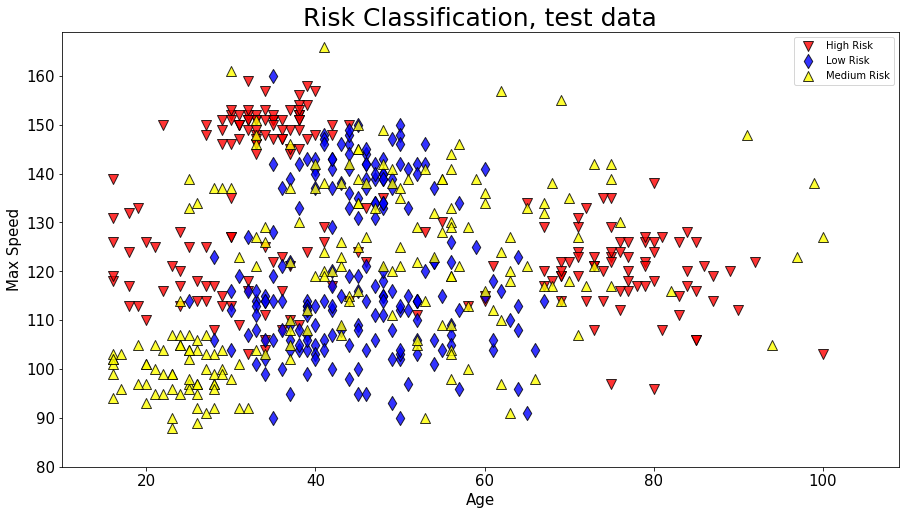

In [18]:
plotPrediction(clf=None, x_data=X_test_2_dim[:, 1], y_data=X_test_2_dim[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y_test,
               title="Risk Classification, test data");

# Step 2: Solving the challenge using traditional coding (software 1.0)

In [0]:
red = high = 0
green = low =1
yellow = medium = 2

probas = np.array([
                   [1, 0, 0],
                   [0, 1, 0],
                   [0, 0, 1]
])

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def predict_proba(self, X):
        return np.array([probas[xi] for xi in self.predict(X)])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n


## A baseline: just random guessing

In [0]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(3)
random_clf = RandomClassifier()        

In [21]:
random_clf.score(X_test_2_dim, y)

0.12866666666666668

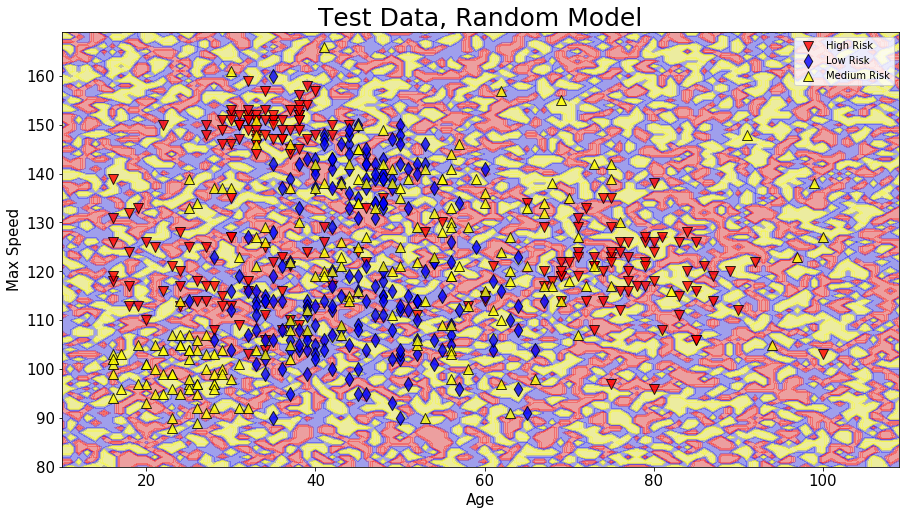

In [22]:
plotPrediction(random_clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0],
               'Age', 'Max Speed', y_test,
                title="Test Data, Random Model");

## Shared exercise: Let's come up with some good for this challenge 

In [0]:
class RuleClassifier(ClassifierBase):
    def predict_single(self, x):
        speed, age = x
        return low
rule_clf = RuleClassifier()        

In [24]:
rule_clf.score(X_test_2_dim, y)

0.12533333333333332

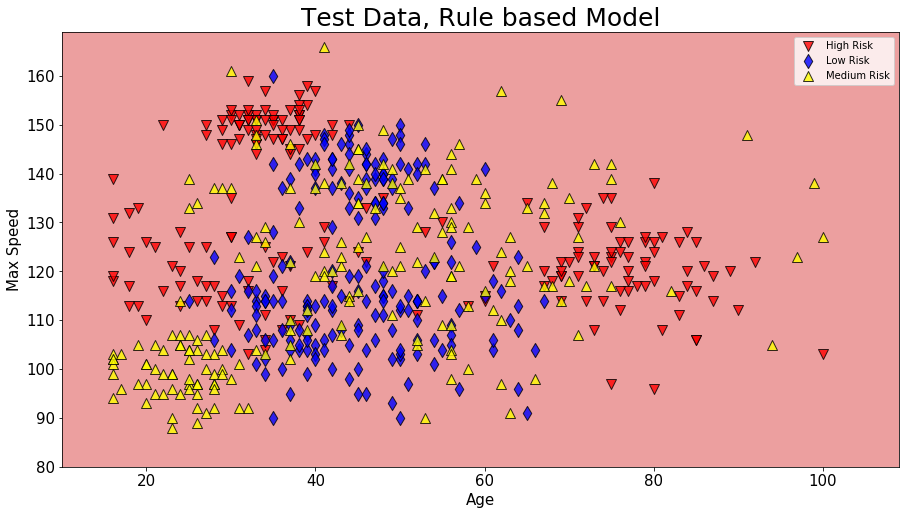

In [25]:
plotPrediction(rule_clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0],
               'Age', 'Max Speed', y_test,
                title="Test Data, Rule based Model");

## My best hand craftet model

In [66]:
class RuleClassifier(ClassifierBase):
    def predict_single(self, x):
        speed, age = x
        if age < 25:
            if speed > 110:
                return high
            else:
                return medium
        if age > 70:
            return high
        if speed > 145:
            return high
        # this default vastly simplifies rule set    
        return low
rule_clf = RuleClassifier()        
rule_clf.score(X_test_2_dim, y_test)

0.5916666666666667

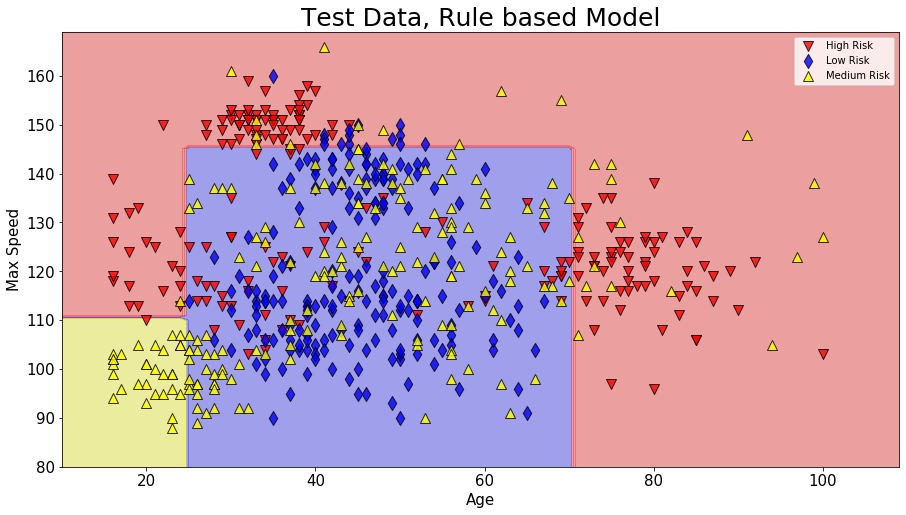

In [27]:
plotPrediction(rule_clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0],
               'Age', 'Max Speed', y_test,
                title="Test Data, Rule based Model");

# Step 3: From Software 1.0 to Software 2.0

## Traditional Software vs Machine Learning

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/classic_vs_ml.jpg?raw=1'>

https://cs.stanford.edu/~matei/ at http://scaledml.org/2020/

# Migrating from Software 1.0 (Classic Code) to 2.0 (Machine Learning)

![from code 1.0 to 2.0](https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/tesla-karpathy-sw-2.jpg?raw=1)

Andrej Karpathy (https://twitter.com/karpathy) at http://scaledml.org/2020/

# Why now?

## Situation in the 90s
<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/1_2_90s.png?raw=1'>

# Situation now
<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/1_2_now.png?raw=1'>

<small>

https://www.hotchips.org/wp-content/uploads/hc_archives/hc29/HC29.22-Tuesday-Pub/HC29.22.69-Key2-AI-ML-Pub/HotChips%20keynote%20Jeff%20Dean%20-%20August%202017.pdf

</small>

# Step 4: Train Neural Network using the data you have and make it generalize well

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, AlphaDropout

num_features = 2
num_categories = 3

dropout = 0.3
selu_dropout_model = tf.keras.Sequential()

selu_dropout_model.add(Input(name='input', shape=(num_features,)))

selu_dropout_model.add(Dense(name='hidden1', units=500, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='hidden2', units=250, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='output', units=num_categories, activation='softmax'))

selu_dropout_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

model = selu_dropout_model

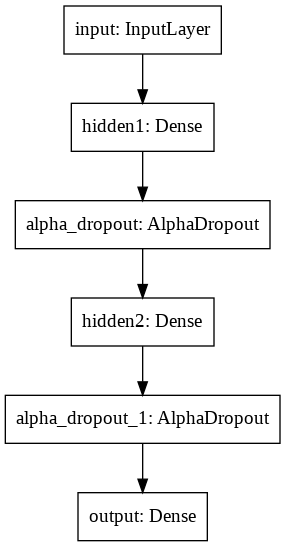

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [30]:
%%time 

# BATCH_SIZE = 10
BATCH_SIZE = 500
EPOCHS = 3000

PATIENCE = 500
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE)

history = model.fit(x = X_train_2_dim,
                    y = y_train,
                    validation_data=(X_test_2_dim, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 49.7 s, sys: 5 s, total: 54.7 s
Wall time: 51.1 s


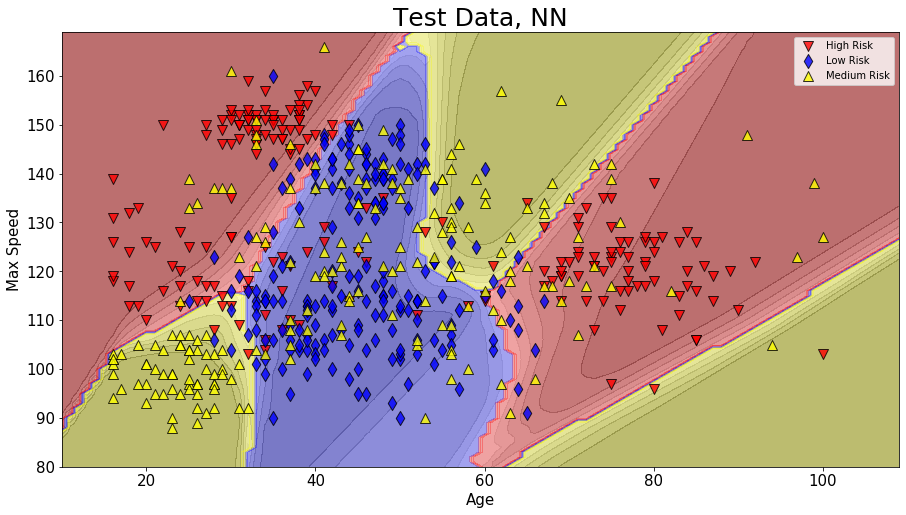

In [31]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN");

# This is ~%70 vs ~60%





## Neural Network

In [32]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_accuracy

0.69166666

## Traditional Software

In [67]:
rule_clf.score(X_test_2_dim, y_test)

0.5916666666666667

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 250)               125250    
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 250)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 753       
Total params: 127,503
Trainable params: 127,503
Non-trainable params: 0
_________________________________________________________________


# Both solutions have pros and cons, none is ideal
1. Tradtional rules make sense to us, but are less powerful and hard to maintain
1. Neural Network maintains itself and is very powerful, but can not be explained (~130k parameters) 

# Main Question: Can we have the best of both worlds?
## Or at least more freedom on how to compromise?

# Step 2: Generate a larger and evenly distributed set of training data by feeding a grid of data through the neural network


In [35]:
xx,yy = meshGrid()
xx.shape, yy.shape

((90, 100), (90, 100))

In [36]:
mesh_data = np.c_[yy.ravel(), xx.ravel()]
mesh_data.shape

(9000, 2)

In [37]:
mesh_data[0]

array([80, 10])

In [38]:
pred = model.predict(mesh_data)
pred.shape

(9000, 3)

In [39]:
pred_sparse = pred.argmax(axis=1)
pred_sparse.shape

(9000,)

In [40]:
np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([4410, 1759, 2831]))

# Step 3: Use this new training data to train a vanilla, unregularized decision tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier()
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 7.13 ms, sys: 0 ns, total: 7.13 ms
Wall time: 7.18 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

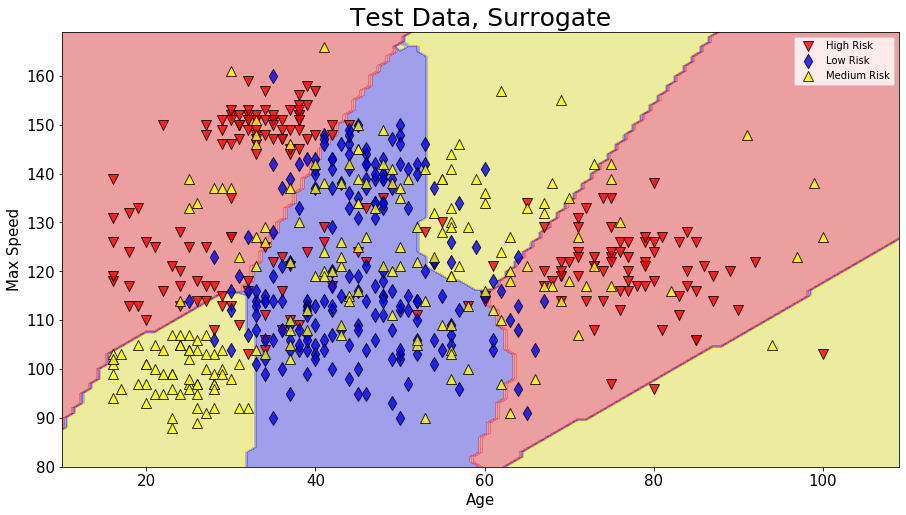

In [42]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [43]:
surrogate_model.tree_.max_depth

12

## Scores on newly generated data

In [44]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

## Scores on original data

In [45]:
surrogate_model.score(X_train_2_dim, y_train)

0.69

In [46]:
surrogate_model.score(X_test_2_dim, y_test)

0.6916666666666667

# Step 4: Use typical regularization for decision tree not to make it generalize better, but to have a dial between explainability and accuracy


In [47]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=random_seed,
    min_samples_leaf = 500,
    max_leaf_nodes = 4
)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 5.06 ms, sys: 0 ns, total: 5.06 ms
Wall time: 11.4 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [48]:
surrogate_model.tree_.max_depth

3

In [49]:
surrogate_model.score(mesh_data, pred_sparse)

0.6774444444444444

In [50]:
surrogate_model.score(X_train_2_dim, y_train)

0.5911111111111111

In [51]:
surrogate_model.score(X_test_2_dim, y_test)

0.6133333333333333

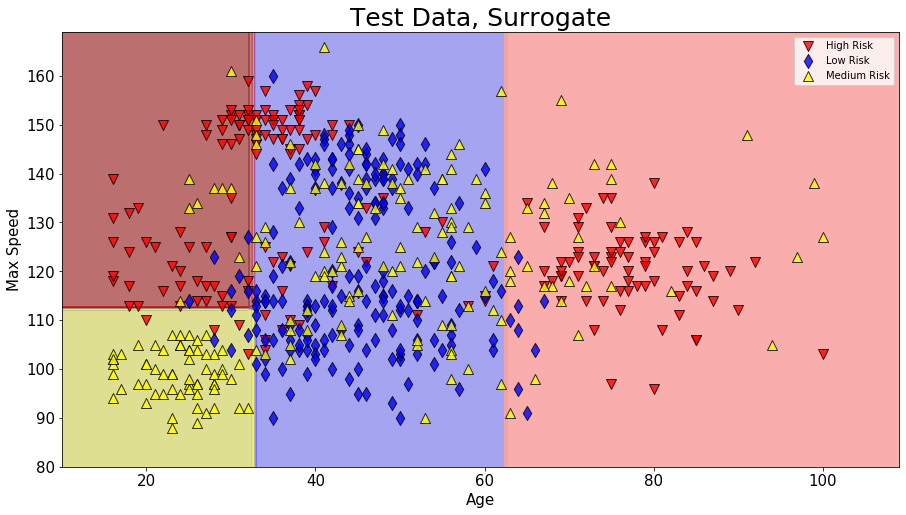

In [52]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

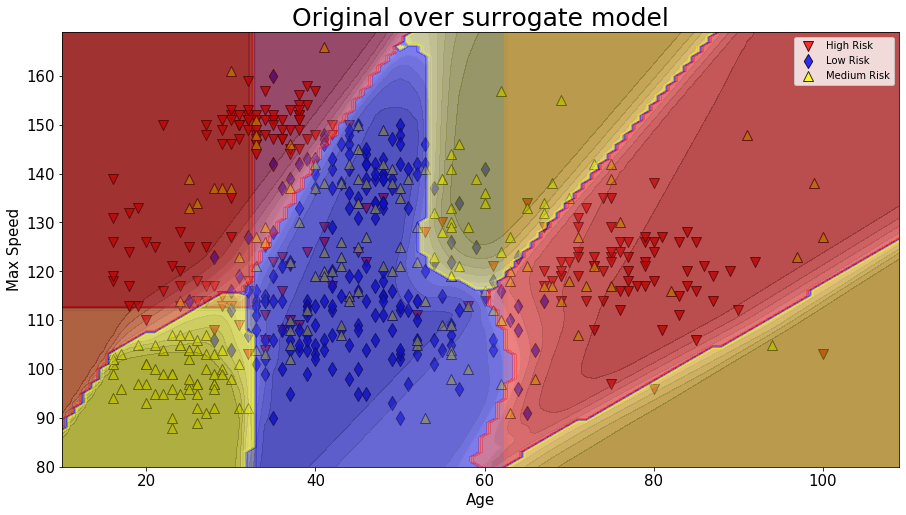

In [53]:
ax = plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test)
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, ax=ax, scatter=False,
                title="Original over surrogate model");

# Step 5: Use tree for explain plan and code generation

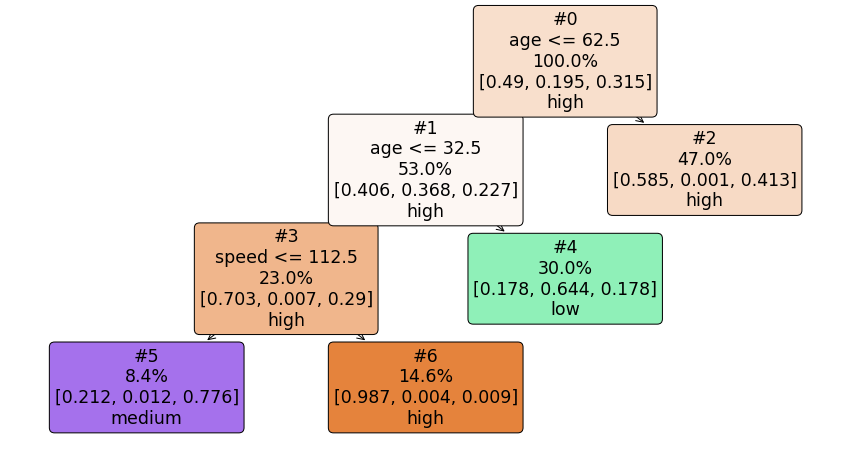

In [54]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['speed', 'age']
class_names=['high', 'low', 'medium']

# plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

In [55]:
# groups: "High Risk", "Low Risk", "Medium Risk"

sample = [110, 35]
# sample = [100, 60]
# sample = [120, 17]

surrogate_model.predict([sample])

array([1])

## Visualizing Prediction Path using dtreeviz

https://github.com/parrt/dtreeviz

In [56]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


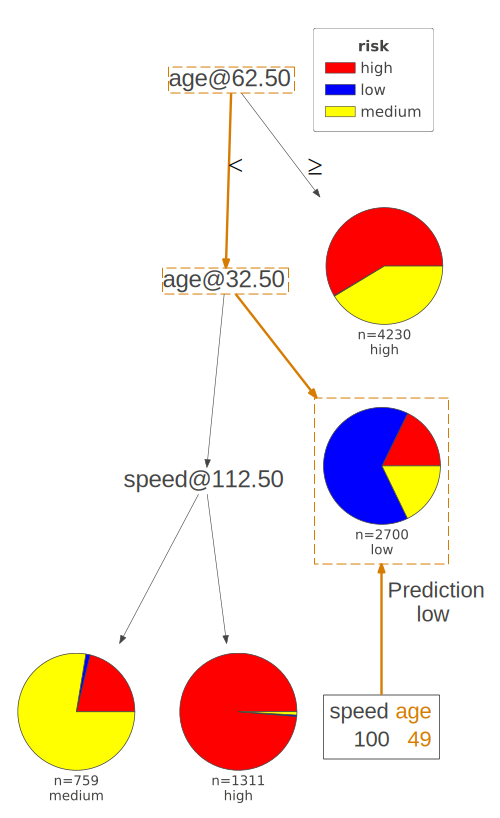

In [57]:
from dtreeviz.trees import dtreeviz

# sample = [100, 35]
# sample = [150, 30]
sample = [100, 49]
# sample = [100, 60]
# sample = [120, 17]

dtreeviz_colors = {'classes': [
                   None,  # 0 classes
                   None,  # 1 classes
                   None,  # 2 classes
                   colors
                   ]}

viz = dtreeviz(surrogate_model,
               mesh_data, pred_sparse,
               target_name='risk',
               feature_names=feature_names,
               class_names=class_names,
               X=sample,
               colors=dtreeviz_colors,
               fancy=False,
               scale=2,
#                scale=3
)
viz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


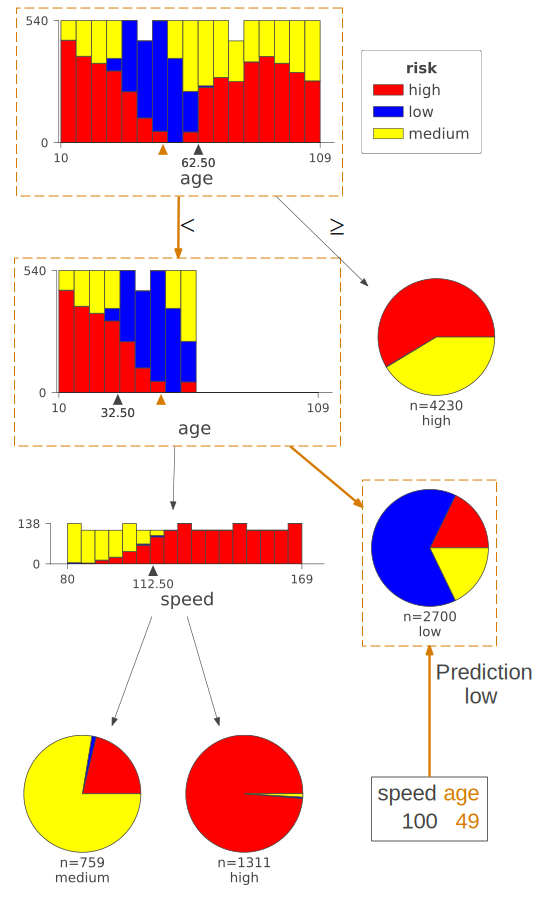

In [58]:
dtreeviz(surrogate_model,
         mesh_data, pred_sparse,
         target_name='risk',
         feature_names=feature_names,
         class_names=class_names,
         X=sample,
         colors=dtreeviz_colors,
         scale=2)

## Explaining decision


In [59]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

from sklearn.tree import _tree

def explain_decision(model, sample, feature_names, class_names):

  feature = model.tree_.feature
  threshold = model.tree_.threshold
  value = model.tree_.value

  node_indicator = model.decision_path([sample])
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]

  for node_id in node_index:
      if feature[node_id] == _tree.TREE_UNDEFINED:
          print(class_names[value[node_id].argmax(axis=1)[0]])
          continue

      if (sample[feature[node_id]] <= threshold[node_id]):
          threshold_sign = "<="
      else:
          threshold_sign = ">"

      print("%s(= %s) %s %s"
            % (feature_names[feature[node_id]],
              sample[feature[node_id]],
              threshold_sign,
              threshold[node_id]))
      
explain_decision(surrogate_model, sample, feature_names, class_names)      

age(= 49) <= 62.5
age(= 49) > 32.5
low


## Generating code

In [60]:
def generate_code(model, feature_names, class_names, batch=True):
    tree_ = model.tree_
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def remove_less_specific_conditions(conditions):
        filered_conditions = []
        for name, op, threshold in conditions:
            if not any([filtered_name 
                    for filtered_name, filtered_op, filtered_threshold 
                    in conditions 
                    if name == filtered_name and 
                        op == filtered_op and 
                        ((op == '<=' and threshold > filtered_threshold) or 
                         (op == '>' and threshold < filtered_threshold))
                       ]):
                filered_conditions.append((name, op, threshold))
        return filered_conditions
    
    def conjunction_on_conditions(conditions):
        conjunction = ' and '.join(["{} {} {}".format(name, op, threshold) for name, op, threshold in conditions])
        return conjunction
    
    def recurse(node, depth, conditions, outputs):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            condition = (name, '<=', threshold)
            recurse(tree_.children_left[node], depth + 1, conditions + [condition], outputs)
            condition = (name, '>', threshold)
            recurse(tree_.children_right[node], depth + 1, conditions + [condition], outputs)
        else:
            prediction = class_names[value[node].argmax(axis=1)[0]]
            conjunction = conjunction_on_conditions(remove_less_specific_conditions(conditions))
            if prediction in outputs: 
              outputs[prediction] += [conjunction] 
            else:
              outputs[prediction] = [conjunction]
        return outputs
              

    outputs = recurse(0, 1, [], {})
    for prediction in outputs.keys():
          conjunctions = outputs[prediction]
          if batch:
            disjunction = ' or\n     '.join(conjunctions)
            print ("  if {}:".format(disjunction))
            print ("    return '{}':".format(prediction))
          else:
            for conjunction in conjunctions:
              print ("  if {}:".format(conjunction))
              print ("    return '{}':".format(prediction))

generate_code(surrogate_model, feature_names, class_names)

def tree(speed, age):
  if age <= 32.5 and speed <= 112.5:
    return 'medium':
  if age <= 32.5 and speed > 112.5 or
     age > 62.5:
    return 'high':
  if age <= 62.5 and age > 32.5:
    return 'low':


In [61]:
generate_code(surrogate_model, feature_names, class_names, batch=False)

def tree(speed, age):
  if age <= 32.5 and speed <= 112.5:
    return 'medium':
  if age <= 32.5 and speed > 112.5:
    return 'high':
  if age > 62.5:
    return 'high':
  if age <= 62.5 and age > 32.5:
    return 'low':


In [0]:
# derived from https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

def generate_nested_code(model, feature_names, class_names):
    tree_ = model.tree_
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            condition = "{} <= {}".format(name, threshold)
            print ("{}if {}:".format(indent, condition))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {}".format(indent, condition))
            recurse(tree_.children_right[node], depth + 1)
        else:
            prediction = class_names[value[node].argmax(axis=1)[0]]
            print ("{}return '{}'".format(indent, prediction))

    recurse(0, 1)

In [63]:
generate_nested_code(surrogate_model, feature_names, class_names)

def tree(speed, age):
  if age <= 62.5:
    if age <= 32.5:
      if speed <= 112.5:
        return 'medium'
      else:  # if speed <= 112.5
        return 'high'
    else:  # if age <= 32.5
      return 'low'
  else:  # if age <= 62.5
    return 'high'


# Step 6: When to apply Machine Learning?

***Once your legacy system holds code that nobody understands any more, implements obscure business rules that people have forgotten years ago, has pieces that nobody uses, and massive complexity meant to cover future eventualities that never happened, it's time to toss it.***

https://twitter.com/allenholub/status/1225183786939236352

# Which parts of your code can you replace with Machine Learning?

* the problem at hand is hard to specify
* solving the problem can tolerate some error or uncertainty
* you have sample data with labels (ground truth) or can simulate your environment
* there is a clear, simple input and output